# River Boundary Masking

## Introduction

TODO

In [5]:
# !pip install -q torch transformers datasets tqdm monai

In [6]:
# !pip install -q huggingface_hub
fetch_updated = False

# if fetch_updated:
#     !huggingface-cli login

In [7]:
from datasets import load_dataset, load_from_disk, Dataset

training_data_path = "./elwha-dataset-tiny-train.hf"
validation_data_path = "./elwha-dataset-tiny-val.hf"

if fetch_updated:
    print("Fetchng data from huggingface server...")
    training_data: Dataset = load_dataset("stodoran/elwha-segmentation-tiny", split="train")  # type: ignore
    validation_data: Dataset = load_dataset("stodoran/elwha-segmentation-tiny", split="validation")  # type: ignore
    training_data.save_to_disk(training_data_path)
    validation_data.save_to_disk(validation_data_path)
else:
    print("Loading data from disk...")
    training_data = load_from_disk(training_data_path)  # type: ignore
    validation_data = load_from_disk(validation_data_path)  # type: ignore

print(training_data)
print(validation_data)

Loading data from disk...
Dataset({
    features: ['image', 'label'],
    num_rows: 203
})
Dataset({
    features: ['image', 'label'],
    num_rows: 22
})


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def overlay_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_control_points(coords, labels, ax, min_distance=None, marker_size=375):
    if len(coords) == 0 or len(labels) == 0: return
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    if min_distance is not None:
        for point in pos_points:
            circle = Circle((point[0], point[1]), min_distance, color="white", fill=False, linestyle="dashed")
            ax.add_patch(circle)

        for point in neg_points:
            circle = Circle((point[0], point[1]), min_distance, color="white", fill=False, linestyle="dashed")
            ax.add_patch(circle)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker="P", s=marker_size, edgecolor="white", linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker="X", s=marker_size, edgecolor="white", linewidth=1.25)

def show_bounding_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2))  # type: ignore

def preview_datapoint(datapoint, points=None, bbox=None, mask=True, min_distance=None):
    fig, axes = plt.subplots()

    axes.imshow(datapoint["image"])
    if mask: overlay_mask(np.array(datapoint["label"]), axes)
    if points: show_control_points(*points, axes, min_distance)  # type: ignore
    if bbox: show_bounding_box(bbox, axes)

    axes.axis("off")

In [9]:
np.random.seed(0)

In [10]:
from skimage.morphology import erosion
from enum import Enum

square = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1],
])

def multi_erode(im, num, element=square):  # TODO: Figure out if needed, this is currently unused.
    for _ in range(num):
        im = erosion(im, element)
    return im

def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def zero_out_circle(target_mask, center, radius):
    rows, cols = np.ogrid[:target_mask.shape[0], :target_mask.shape[1]]
    circular_mask = (rows - center[1])**2 + (cols - center[0])**2 <= radius**2
    target_mask[circular_mask] = 0
    return target_mask

class LoggingMode(Enum):
    QUIET = 0
    NORMAL = 1
    VERBOSE = 2

In [11]:
def pick_points_in_mask(mask, number, distance=0, positive=False, existing_points=[], logging=LoggingMode.QUIET):
    target_mask = np.copy(mask)
    input_points = []

    if distance > 0:
        for point in existing_points:
            zero_out_circle(target_mask, point, distance)

    while len(input_points) < number:
        valid_indices = np.argwhere(target_mask != 0) if positive else np.argwhere(target_mask == 0)

        if len(valid_indices) == 0:
            if logging.value >= LoggingMode.NORMAL.value:
                print(f"Found only {len(input_points)} control points when {number} requested.")
                print("No valid points left.")
            break  # We have fewer than "number" points, but there are no valid points left.
        # END IF

        # TODO: Selection of point position could potentially be improved. If the point is too near 
        # the edge (judged by the distance to the nearest invalid index) then try picking again.
        random_index = np.random.randint(0, len(valid_indices))
        row, col = valid_indices[random_index]
        new_point = [col, row]

        input_points.append(new_point)
        if distance > 0:
            zero_out_circle(target_mask, new_point, distance)
    # END WHILE

    return np.array(input_points)

def determine_dynamic_distance(mask, positive=True, logging=LoggingMode.QUIET):
    one_indices = np.array(mask != 0) if positive else np.array(mask == 0)
    # ratio = one_indices.sum() / (mask.shape[0] * mask.shape[1])
    # min_distance = ratio * min(mask.shape[0], mask.shape[1])

    # Works better than the above linear version to have larger min distance values compared to linear
    # for smaller ratios and to not let the min distance grow too much relative to linear for large ratios.
    min_distance = (one_indices.sum() ** 0.5) / 2

    if logging.value >= LoggingMode.VERBOSE.value:
        print(f"Total in mask sum is {one_indices.sum()}")
        print(f"Using dynamic distance value of {min_distance}")

    return min_distance

def generate_input_points(
    number=None,
    mask=None,
    min_distance: int = 0,
    dynamic_distance=False,
    negative_src_mask=None,
    num_negative=None,
    positive_src_mask=None,
    num_positive=None,
    perturbation=0,  # TODO: Implement this! Would allow points outside of the true mask.
    logging: LoggingMode = LoggingMode.QUIET,
):
    input_points = []
    input_labels = []

    _num_positive = num_positive if num_positive is not None else number
    if _num_positive is not None:
        src_mask = positive_src_mask if positive_src_mask is not None else mask
        if dynamic_distance:
            min_distance = determine_dynamic_distance(src_mask)

        control_points = pick_points_in_mask(
            src_mask,
            _num_positive,
            distance=min_distance,
            positive=True,
            logging=logging,
        )
        input_points.extend(control_points)
        input_labels.extend([1] * len(control_points))

        if len(input_points) < _num_positive:
            pad_amnt = _num_positive - len(input_points)
            input_points.extend([(0, 0)] * pad_amnt)
            input_labels.extend([-10] * pad_amnt)

            if logging.value >= LoggingMode.NORMAL.value:
                print(
                    f"Found {len(input_points)} control points when {_num_positive} requested, padding with {pad_amnt} pad points.")
    # END POSITIVE CONTROL POINT PICKING

    _num_negative = num_negative if num_negative is not None else number
    if _num_negative is not None:
        src_mask = negative_src_mask if negative_src_mask is not None else mask
        if dynamic_distance:
            min_distance = determine_dynamic_distance(src_mask)

        control_points = pick_points_in_mask(
            src_mask,
            _num_negative,
            distance=min_distance,
            existing_points=input_points,
            logging=logging,
        )
        input_points.extend(control_points)
        input_labels.extend([0] * len(control_points))

        if len(input_points) < _num_negative:
            pad_amnt = _num_negative - len(input_points)
            input_points.extend([(0, 0)] * pad_amnt)
            input_labels.extend([-10] * pad_amnt)

            if logging.value >= LoggingMode.NORMAL.value:
                print(
                    f"Found {len(input_points)} control points when {_num_negative} requested, padding with {pad_amnt} pad points.")
    # END NEGATIVE CONTROL POINT PICKING

    input_points = np.array(input_points)
    input_labels = np.array(input_labels)

    return input_points, input_labels

def get_input_bbox(mask, perturbation=0):
    # Find minimum mask bounding all included mask points.
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    if perturbation:  # Add perturbation to bounding box coordinates.
        H, W = mask.shape
        x_min = max(0, x_min + np.random.randint(-perturbation, perturbation))
        x_max = min(W, x_max + np.random.randint(-perturbation, perturbation))
        y_min = max(0, y_min + np.random.randint(-perturbation, perturbation))
        y_max = min(H, y_max + np.random.randint(-perturbation, perturbation))

    bbox = [x_min, y_min, x_max, y_max]
    return bbox

TODO: 
* Should we erode the mask before picking training control points, the way we do at inference time usually? Perhaps just erode less than inference time?
* Should we use a technique with erosion to find the main river portion, the subtract it from the original mask to get the smaller feeder streams? Could use this to place control points more strategically.

In [12]:
import ipywidgets as widgets
import cv2

datapoint_slider = widgets.IntSlider(
    value=1, min=0, max=len(training_data) - 1, step=1,
    description="Datapoint:"
)
prev_button = widgets.Button(
    description="Prev",
    tooltip="Prev",
    disabled=False,
    button_style="",
    icon="arrow-left"
)
next_button = widgets.Button(
    description="Next",
    tooltip="Next",
    disabled=False,
    button_style="",
    icon="arrow-right"
)

def change_slider_value(diff):
    next_value = datapoint_slider.value + diff
    if next_value > datapoint_slider.min and next_value < datapoint_slider.max:
        datapoint_slider.value = next_value

def incrementSliderValue(_ignore): change_slider_value(1)
def decrementSliderValue(_ignore): change_slider_value(-1)
prev_button.on_click(decrementSliderValue)
next_button.on_click(incrementSliderValue)

trigger_refresh_btn = widgets.ToggleButton(
    value=True,
    description="Randomize",
    disabled=False,
)

def handle_widgets_update(datapoint_index: int, _randomize):
    sample_datapoint = training_data[datapoint_index]
    sample_datapoint = {
        "image": cv2.resize(np.array(sample_datapoint["image"]), (256, 256)),
        "label": cv2.resize(np.array(sample_datapoint["label"]), (256, 256)),
    }

    points = generate_input_points(
        num_positive=5,
        mask=sample_datapoint["label"],
        dynamic_distance=True,
        logging=LoggingMode.VERBOSE
    )
    bbox = get_input_bbox(sample_datapoint["label"], perturbation=20)

    # We only need to bother with this for the visualization
    min_distance = determine_dynamic_distance(sample_datapoint["label"], logging=LoggingMode.VERBOSE)
    preview_datapoint(sample_datapoint, points=points, bbox=bbox, mask=True, min_distance=min_distance)

stepper_buttons = widgets.HBox([prev_button, next_button])
interactive_plot = widgets.interactive(
    handle_widgets_update,
    datapoint_index=datapoint_slider,
    _randomize=trigger_refresh_btn,
)
display(stepper_buttons, interactive_plot)

interactive(children=(IntSlider(value=1, description='Datapoint:', max=202), ToggleButton(value=True, descript…

In [57]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        datapoint = self.dataset[idx]
        input_image = cv2.resize(np.array(datapoint["image"]), (256, 256)) # This doesn't need to be 256x256 per se.
        ground_truth_mask = cv2.resize(np.array(datapoint["label"]), (256, 256)) # This needs to be 256x256 since that is the size of model outputs.

        # Get control points prompt.
        input_points, input_labels = generate_input_points(
            num_positive=5,
            mask=ground_truth_mask,
            dynamic_distance=True,
            logging=LoggingMode.QUIET
        )
        input_points = input_points.astype(float).tolist()
        input_labels = input_labels.tolist()
        input_labels = [[x] for x in input_labels]

        # Prepare the image and prompt for the model.
        inputs = self.processor(
            input_image,
            input_points=input_points,
            input_labels=input_labels,
            return_tensors="pt"
        )

        # Remove batch dimension which the processor adds by default.
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        # inputs["input_points"] = inputs["input_points"].squeeze(1)
        inputs["input_labels"] = inputs["input_labels"].squeeze(1)

        # Add ground truth segmentation.
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [14]:
from transformers import SamProcessor
from torch.utils.data import DataLoader

model_size = "base"
# model_size = "huge"
model_name = f"facebook/sam-vit-{model_size}"

processor = SamProcessor.from_pretrained(model_name)
print(f"Loaded {model_name} model processor")

Loaded facebook/sam-vit-base model processor


In [58]:
batch_size = 2 # TODO: Change back to 5 for training.
train_dataset = SAMDataset(dataset=training_data, processor=processor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = SAMDataset(dataset=validation_data, processor=processor)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [59]:
example = train_dataset[0]
for k, v in example.items():
    print(k, v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([5, 1, 2])
input_labels torch.Size([5, 1])
ground_truth_mask (256, 256)


In [47]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_points torch.Size([2, 5, 1, 2])
input_labels torch.Size([2, 5, 1])
ground_truth_mask torch.Size([2, 1024, 1024])


In [28]:
from transformers import SamModel
from torch.optim import AdamW, Optimizer
from typing import Any
import monai

model: Any = SamModel.from_pretrained(model_name)

# Note: Hyperparameter tuning could improve performance here
learning_rate = 7e-6  # 1e-5
weight_decay = 2e-4
optimizer_name = "AdamW"  # Make sure to change this if changing optimizer!

optimizer = AdamW(model.mask_decoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
lossFn = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction="mean")  # type: ignore

print(f"Loaded {model_name} model, using {optimizer_name} optimizer")

Loaded facebook/sam-vit-base model, using AdamW optimizer


In [29]:
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

In [30]:
# from google.colab import drive
# drive.mount("/content/drive/")
# !mkdir -p "drive/MyDrive/checkpoints"

hyperparams = f"_lr={learning_rate}_wd={weight_decay}_bs={batch_size}"
checkpoint_path = "./drive/MyDrive/" + f"checkpoints/{model_size}_{optimizer_name}" + hyperparams + ".pth"
load_checkpoint = False

print("Save checkpoint path:", checkpoint_path)
print("Loading from checkpoint?", load_checkpoint)

Save checkpoint path: ./drive/MyDrive/checkpoints/base_AdamW_lr=7e-06_wd=0.0002_bs=2.pth
Loading from checkpoint? False


If uploading a `.pth` checkpoint to continue from on Google Colab, make sure to wait until it is done uploading before continuing.

In [31]:
import torch

num_epochs = 300
save_every = 50

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

checkpoint = None
if load_checkpoint:
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    print(f"Model checkpoint loaded from: {checkpoint_path}")
    print(f"Resuming training from epoch: {checkpoint['epoch']} of {num_epochs}")

In [32]:
def save_model_checkpoint(model: SamModel, optimizer: Optimizer, epoch: int, best_loss: float, train_losses, validation_losses):
    print(f"Saving checkpoint for epoch {epoch}...")
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "best_loss": best_loss,
        "train_losses": train_losses,
        "validation_losses": validation_losses,
    }
    torch.save(checkpoint, checkpoint_path)

In [33]:
import gc
from tqdm import tqdm

def evaluate_model(model: SamModel, dataloader: DataLoader) -> torch.Tensor:
    # model.eval()
    losses: list[torch.Tensor] = []

    for batch in tqdm(dataloader, desc="Eval"):
        # Forward Pass
        with torch.no_grad():
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                input_points=batch["input_points"].to(device),
                input_labels=batch["input_labels"].to(device),
                multimask_output=False,
            )  # type: ignore

        # Compute Loss
        predicted_masks = outputs.pred_masks.squeeze((1, 2))
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = lossFn(predicted_masks[:, 0], ground_truth_masks)
        losses.append(loss)

        # Avoid Memory Overload
        gc.collect()
        torch.cuda.empty_cache()
    # END FOR

    return sum(losses) / len(losses)  # type: ignore

In [34]:
from statistics import mean

def train_model(model: SamModel, dataloader: DataLoader, checkpoint=None, eval_every=5):
    model.train()

    epoch = 0
    best_loss = float("inf")
    train_losses = []
    validation_losses = []

    if checkpoint:
        epoch = checkpoint["epoch"] + 1  # Start from the next epoch
        best_loss = checkpoint["best_loss"]
        train_losses = checkpoint["train_losses"]
        validation_losses = checkpoint["validation_losses"]
        print(f"Resuming from checkpoint at epoch {checkpoint['epoch']}")

    while epoch < num_epochs:
        epoch_losses = []

        for batch in tqdm(dataloader, desc="Train Batch"):
            # Forward Pass
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                input_points=batch["input_points"].to(device),
                input_labels=batch["input_labels"].to(device),
                multimask_output=False,
            )

            # Compute Loss
            predicted_masks = outputs.pred_masks.squeeze((1, 2))
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = lossFn(predicted_masks[:, 0], ground_truth_masks)

            # Backward Pass (compute gradients of parameters w.r.t. loss)
            optimizer.zero_grad()
            loss.backward()

            # Optimize Step
            optimizer.step()
            epoch_losses.append(loss.item())
        # END FOR

        if epoch % eval_every == 0:
            # TODO: train_dataloader is passed as a function arg, should validation_dataloader be passed too?
            validation_loss = evaluate_model(model, validation_dataloader)
            validation_losses.append(validation_loss.item())

        mean_loss = mean(epoch_losses)
        if epoch % save_every == 0 or epoch == num_epochs - 1:
            if mean_loss < best_loss:
                save_model_checkpoint(model, optimizer, epoch, mean_loss, train_losses, validation_losses)
                best_loss = mean_loss  # TODO: Should we evaluate on validation every epoch, then save based on best validation loss?
            else:
                print(f"Skipping checkpoint save since prev checkpoint is better: {best_loss} < {mean_loss}")
        # END IF

        print(f"Epoch: {epoch + 1}/{num_epochs}")
        print(f"Mean loss: {mean_loss}")
        train_losses.append(mean_loss)
        epoch += 1
    # END WHILE

    return train_losses, validation_losses

In [21]:
# Evaluate baseline train data performance:
print("Average train loss:", evaluate_model(model, train_dataloader))

# Evaluate zero-shot model performance:
print("\nAverage validation loss:", evaluate_model(model, validation_dataloader))

# TODO: Probably include the test set here in the future too.

In [ ]:
eval_every = 5
train_losses, validation_losses = train_model(model, train_dataloader, checkpoint, eval_every=eval_every)

In [ ]:
val_loss_epochs = [i * eval_every for i in range(len(validation_losses))]

plt.plot(train_losses, label="Train")
plt.plot(val_loss_epochs, validation_losses, label="Validation")
plt.title(f"Epoch vs Loss (model={model_size}, optim={optimizer_name}, lr={learning_rate}, wd={weight_decay}, bs={batch_size})")
plt.xlabel("Training Epoch #")
plt.ylabel("Mean Epoch Train Loss")
plt.legend();

| Model        | Optimizer | Learning Rate   | Weight Decay | Batch Size | Epochs | Prompts | Train Loss | Validation Loss |
|--------------|-----------|-----------------|--------------|------------|--------|---------|------------|-----------------|
| sam-vit-base | AdamW     | 1e-5            | 0            | 2          | 300    | points  | 220.9510   | 235.2056        |
| sam-vit-base | AdamW     | 3e-5            | 0            | 3          | 300    | points  | 220.3394   | 245.4707        |
| sam-vit-base | AdamW     | 7e-6            | 0            | 3          | 600    | points  | 220.4751   | 223.8311        |
| sam-vit-base | AdamW     | 7e-6            | 1e-4         | 4          | 300    | points  | 222.0167   | 219.9485        |
| sam-vit-base | AdamW     | 7e-6            | 1e-5         | 5          | 200    | points  | 224.3772   | 220.1452        |
| sam-vit-huge | AdamW     | 1e-5            | 0            | 2          | 200    | points  | 221.4048   | 255.4305        |

In [ ]:
# Evaluate performance after training:
print("Average train loss:", evaluate_model(model, train_dataloader))
print("\nAverage validation loss:", evaluate_model(model, validation_dataloader))

In [77]:
def visualize_prediction_quality(raw_prediction, final_mask, ground_truth, input_points, input_labels, loss):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    overlay_mask(raw_prediction, axes[0])
    overlay_mask(final_mask, axes[1])
    axes[2].imshow(ground_truth)

    for ax in axes: ax.axis("off")

    axes[0].title.set_text(f"loss={loss}")
    show_control_points(input_points / 4, input_labels, axes[1])
    show_control_points(input_points / 4, input_labels, axes[2])

In [80]:
def visually_evaluate_model(model: SamModel, dataloader: DataLoader, displayCount: int = float("inf")):
    model.eval()
    iterCount = 0

    for batch in tqdm(dataloader, desc="Eval"):
        # Forward Pass
        with torch.no_grad():
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                input_points=batch["input_points"].to(device),
                input_labels=batch["input_labels"].to(device),
                multimask_output=False,
            )  # type: ignore
        
        outputs = outputs.pred_masks.squeeze((1, 2))
        predicted_masks = torch.sigmoid(outputs)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)

        for batch_item in range(predicted_masks.shape[0]):
            loss = lossFn(outputs[batch_item, 0], ground_truth_masks[batch_item])

            raw_mask = predicted_masks[batch_item, 0].cpu().numpy()
            mask = (raw_mask > 0.5).astype(np.uint8)  # TODO: Replace 0.5 with variable confidence threshold.

            visualize_prediction_quality(
                raw_mask,
                mask,
                batch["ground_truth_mask"][batch_item],
                batch["input_points"][batch_item],
                batch["input_labels"][batch_item],
                loss,
            )

        if iterCount >= displayCount:
            break
        iterCount += 1
    # END FOR

Eval:   9%|▉         | 1/11 [00:25<04:18, 25.86s/it]


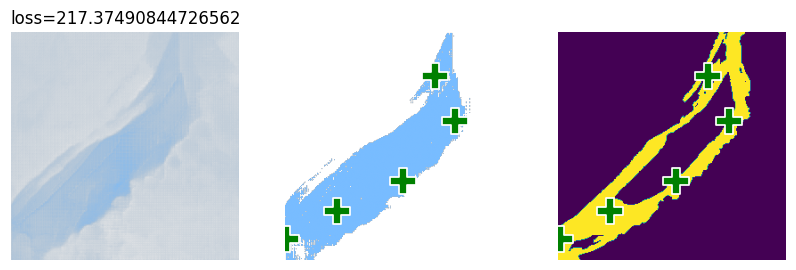

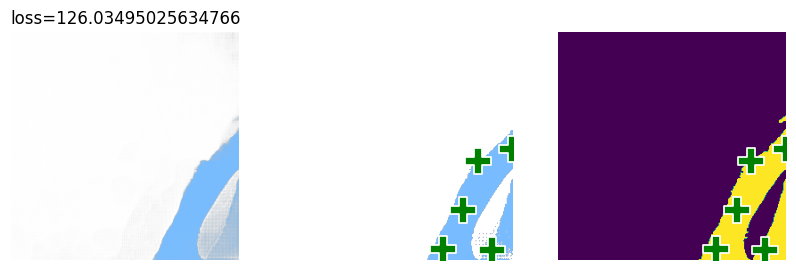

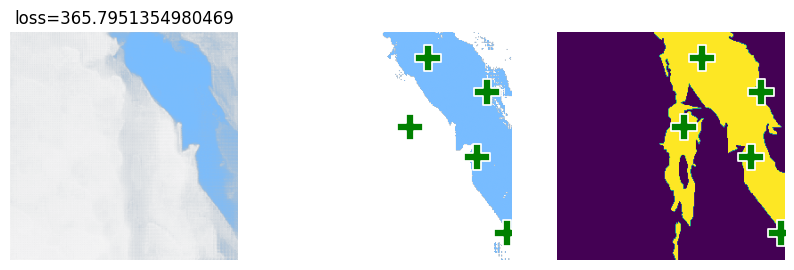

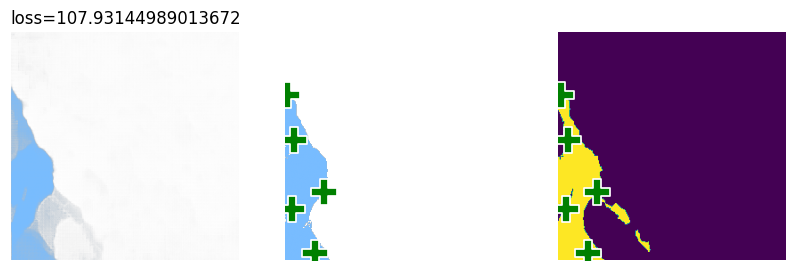

In [81]:
visually_evaluate_model(model, validation_dataloader, displayCount=1)